# Ontario Inpatient Discharges: Observed Trends and Forward Forecast to 2034

This notebook examines historical inpatient discharge trends in Ontario and produces a conservative forward-looking forecast through 2034. The objective is to support long-term healthcare capacity planning by translating observed demand patterns into a realistic planning baseline.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# Load cleaned dataset
df = pd.read_csv("/content/canada_hospital_inpatient_clean_1995_2024.csv")

In [2]:
# Ontario only
ontario = df[df["Province_Territory"] == "Ontario"]

ontario.head()

,Fiscal_Year,Province_Territory,Age_Group,Sex,Number_of_Discharges,Total_Length_of_Stay_Days,Average_Length_of_Stay_Days
300,2023–2024,Ontario,00–04,All,44641.0,223893.0,5.015412
301,2023–2024,Ontario,00–04,Female,19363.0,98408.0,5.082270
302,2023–2024,Ontario,00–04,Male,25273.0,125468.0,4.964508
303,2023–2024,Ontario,05–09,All,14253.0,46338.0,3.251105
304,2023–2024,Ontario,05–09,Female,6303.0,21368.0,3.390132


Annual inpatient discharge data are aggregated by fiscal year to align with how hospital capacity, funding, and workforce planning are conducted in Ontario. Using annual data allows long-term demand patterns to be assessed without short-term volatility.


In [3]:
ontario_yearly = (
    ontario.groupby("Fiscal_Year", as_index=False)["Number_of_Discharges"]
    .sum()
)

ontario_yearly = ontario_yearly.reset_index(drop=True)
ontario_yearly["Year_Index"] = range(len(ontario_yearly))


In [4]:
covid_years = [
    "2019–2020",
    "2020–2021",
    "2021–2022",
    "2022–2023"
]


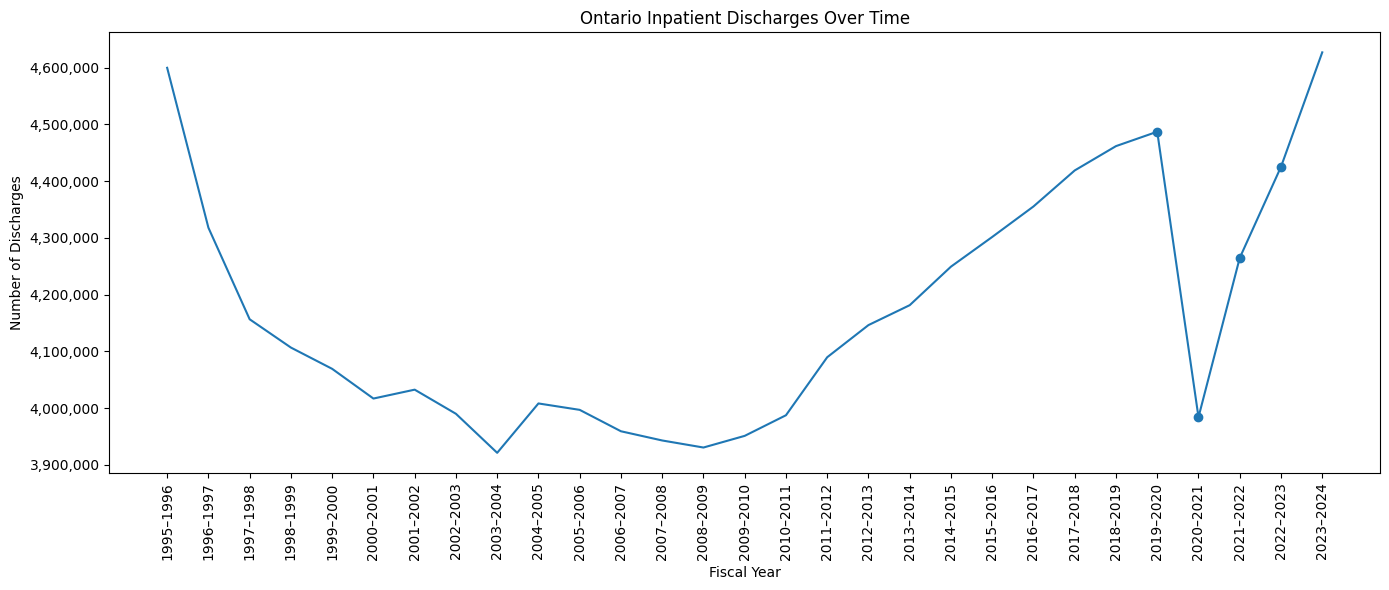

In [5]:
ontario_yearly["Period"] = "Baseline"
ontario_yearly.loc[
    ontario_yearly["Fiscal_Year"].isin(covid_years),
    "Period"
] = "COVID"

covid_mask = ontario_yearly["Period"] == "COVID"
plt.figure(figsize=(14,6))
plt.plot(
    ontario_yearly["Fiscal_Year"],
    ontario_yearly["Number_of_Discharges"],
    label="Ontario"
)
plt.scatter(
    ontario_yearly.loc[covid_mask, "Fiscal_Year"],
    ontario_yearly.loc[covid_mask,
                       "Number_of_Discharges"], )
plt.title("Ontario Inpatient Discharges Over Time")
plt.xlabel("Fiscal Year")
plt.ylabel("Number of Discharges")
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
plt.tight_layout()
plt.show()

The observed data show a long-term increase in inpatient discharges following a period of decline in the early 2000s. A sharp drop is visible during the COVID-19 period, followed by a strong recovery. This historical context provides the baseline from which future demand is projected.


In [6]:
ontario_yearly.columns


Index(['Fiscal_Year', 'Number_of_Discharges', 'Year_Index', 'Period'], dtype='object')

In [7]:
observed_series = ontario_yearly["Number_of_Discharges"].values

In [8]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

forecast_model = ExponentialSmoothing(
    observed_series,
    trend="add",
    damped_trend=True,
    seasonal=None
).fit()


A damped exponential smoothing model is used to generate the forecast. This approach captures long-term trends while allowing growth to slow over time, reflecting real-world constraints such as staffing availability, physical capacity, and funding limitations. The model is fitted to the full observed series, including the post-pandemic recovery period.


In [9]:
future_years = [
    "2024–2025",
    "2025–2026",
    "2026–2027",
    "2027–2028",
    "2028–2029",
    "2029–2030",
    "2030–2031",
    "2031–2032",
    "2032–2033",
    "2033–2034"
]


In [10]:
future_values = forecast_model.forecast(len(future_years))

In [11]:
last_obs_idx = ontario_yearly["Year_Index"].max()

future_df = pd.DataFrame({
    "Fiscal_Year": future_years,
    "Forecast_Discharges": future_values,
    "Year_Index": range(
        last_obs_idx + 1,
        last_obs_idx + 1 + len(future_years)
    )
})


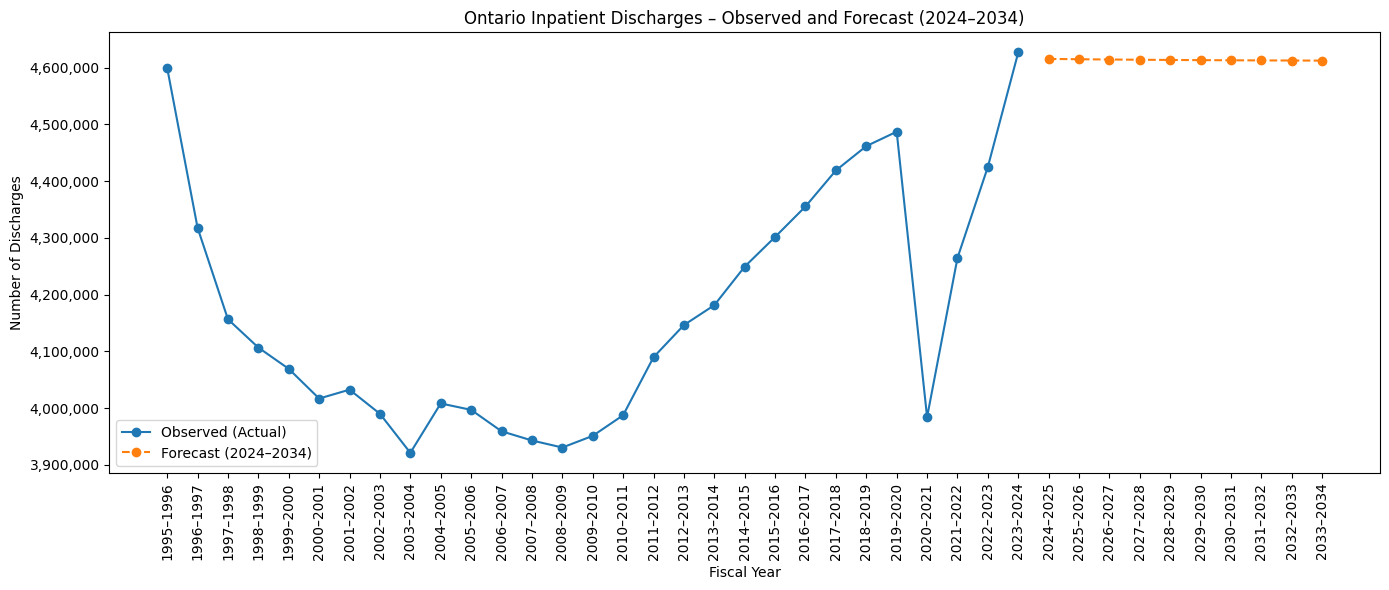

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

plt.figure(figsize=(14,6))

# Observed data
plt.plot(
    ontario_yearly["Year_Index"],
    ontario_yearly["Number_of_Discharges"],
    marker="o",
    label="Observed (Actual)"
)

# Future forecast
plt.plot(
    future_df["Year_Index"],
    future_df["Forecast_Discharges"],
    linestyle="--",
    marker="o",
    label="Forecast (2024–2034)"
)

# X-axis labels
axis_df = pd.concat([
    ontario_yearly[["Year_Index", "Fiscal_Year"]],
    future_df[["Year_Index", "Fiscal_Year"]]
]).sort_values("Year_Index")

plt.xticks(
    axis_df["Year_Index"][::1],
    axis_df["Fiscal_Year"][::1],
    rotation=90
)

plt.title("Ontario Inpatient Discharges – Observed and Forecast (2024–2034)")
plt.xlabel("Fiscal Year")
plt.ylabel("Number of Discharges")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
plt.legend()
plt.tight_layout()
plt.show()


This figure extends observed inpatient discharge trends through 2034. The forecast suggests that, following post-pandemic recovery, inpatient activity is expected to stabilise rather than accelerate rapidly. This reflects a system operating under capacity constraints, where growth in demand does not automatically translate into equivalent growth in delivered care.


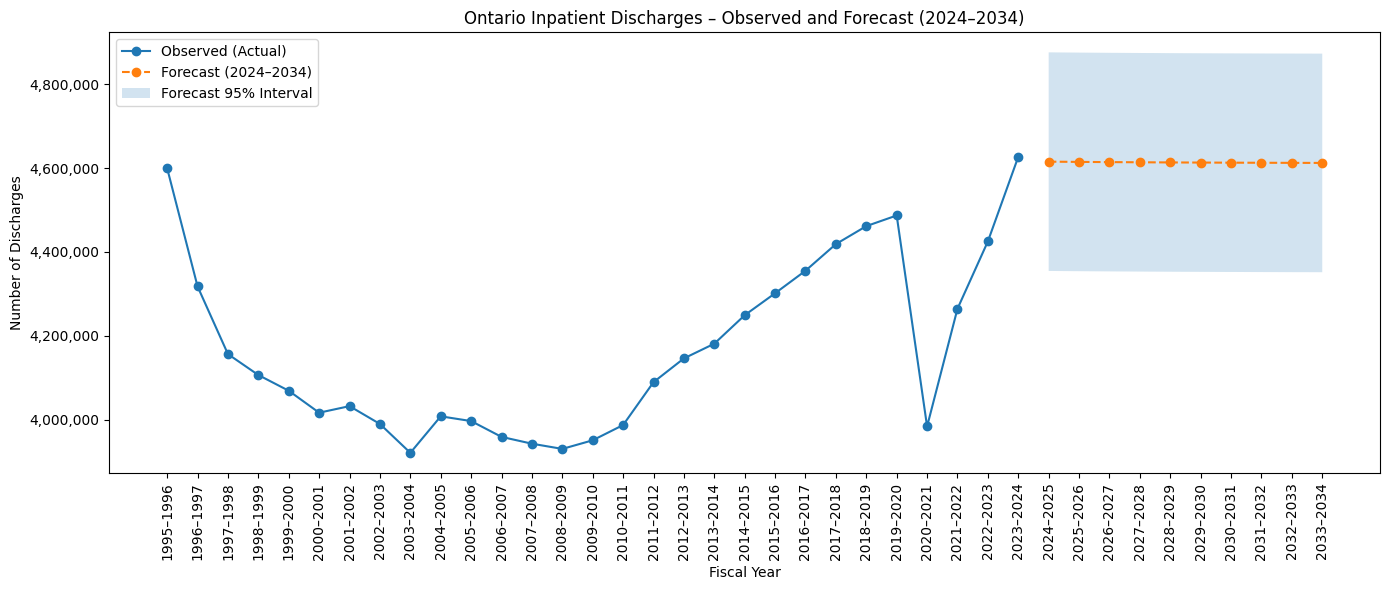

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

plt.figure(figsize=(14,6))

# Observed data
plt.plot(
    ontario_yearly["Year_Index"],
    ontario_yearly["Number_of_Discharges"],
    marker="o",
    label="Observed (Actual)"
)

# Future forecast
plt.plot(
    future_df["Year_Index"],
    future_df["Forecast_Discharges"],
    linestyle="--",
    marker="o",
    label="Forecast (2024–2034)"
)

# X-axis labels
axis_df = pd.concat([
    ontario_yearly[["Year_Index", "Fiscal_Year"]],
    future_df[["Year_Index", "Fiscal_Year"]]
]).sort_values("Year_Index")

plt.xticks(
    axis_df["Year_Index"][::1],
    axis_df["Fiscal_Year"][::1],
    rotation=90
)

plt.title("Ontario Inpatient Discharges – Observed and Forecast (2024–2034)")
plt.xlabel("Fiscal Year")
plt.ylabel("Number of Discharges")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
import numpy as np

sigma = np.std(forecast_model.resid)

future_df["Lower_Bound"] = future_df["Forecast_Discharges"] - 1.96 * sigma
future_df["Upper_Bound"] = future_df["Forecast_Discharges"] + 1.96 * sigma

plt.fill_between(
    future_df["Year_Index"],
    future_df["Lower_Bound"],
    future_df["Upper_Bound"],
    alpha=0.2,
    label="Forecast 95% Interval"
)
plt.legend()
plt.tight_layout()
plt.show()


From a planning perspective, the forecast indicates sustained inpatient demand at levels above pre-pandemic norms. Even under conservative assumptions, this implies continued pressure on hospital throughput, staffing, and bed availability. The results should be interpreted as a planning baseline rather than a precise prediction.


### Policy relevance

The forward-looking forecast provides a conservative estimate of inpatient demand that can inform medium- and long-term planning decisions. By focusing on stable trends rather than short-term fluctuations, the analysis supports evidence-based discussions around capacity investment, workforce planning, and system sustainability in Ontario’s publicly funded healthcare system.
